# Taller 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import beta

##### 1. Consideremos el modelo Beta Binomial dado por:
* $Y|\pi \sim \text{Bin}(2,\pi)$
* $\pi \sim \text{Beta}(2,3)$

y entonces tendremos que: $\pi|(Y=1)\sim\text{Beta}(3,4)$.

Nuestra densidad objetivo a simular será:
$$f(\pi|y=1) \propto f(\pi)f(y=1|\pi)$$
Simule de la densidad anterior usando un algoritmo Metropolis-Hastings con densidad instrumental $q(\cdot, x) \sim  \text{Beta}(a,b)$.

_Solución:_ Definimos la densidad objetivo y la instrumental.

In [2]:
f = lambda x : 1/12*x*(1-x)**2 * 2*x*(1-x)

In [3]:
a, b = 3, 2

def g(x=0, sim=False):
    if sim:
        return beta(a,b).rvs()
    return beta(a,b).pdf(x)

Implementamos le algoritmo Metropolis-Hastings independiente.

In [4]:
def MH_indep(f,g,x,N=1_000):
    '''
    Implementación del algoritmo Metropolis-Hastings independiente
    '''
    L = np.array([x])
    for _ in range(N):
        y = g(sim=True)
        u = np.random.uniform()
        a = 0 if f(L[-1])*g(y) == 0 else min(1, f(y)*g(L[-1]) / (f(L[-1])*g(y)) )
        L = np.append(L, y) if u < a else np.append(L, L[-1])
    return L

In [5]:
%%time
x0 = 0.5   # punto partida
N = 50_000 # número de simulaciones

L = MH_indep(f,g,x0,N)
L

CPU times: total: 1min 31s
Wall time: 1min 32s


array([0.5       , 0.5936023 , 0.53764445, ..., 0.70245016, 0.42932392,
       0.53978351])

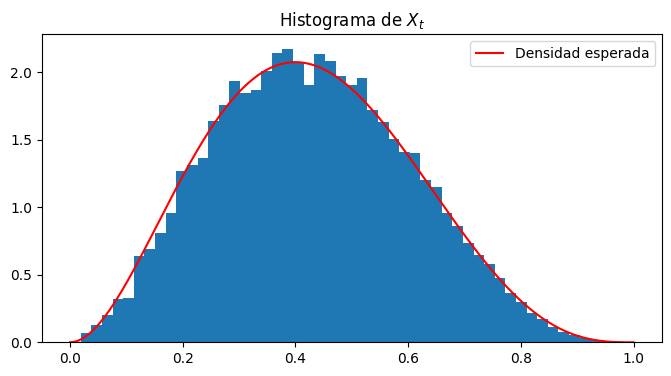

In [6]:
puntos = np.linspace(0,1,1_000)

plt.figure(figsize = (8,4))
plt.hist(L, bins = 50, density = True, zorder = 0)
plt.plot(puntos, f(puntos) / (1/360), # normalizamos para que sea comparable
         zorder = 1, c = 'red', label = 'Densidad esperada'
        )
plt.title(f'Histograma de $X_t$')
plt.legend(); plt.show()

##### 2. Nuestra densidad objetivo es una versión perturbada de una distribución normal, $\psi(\cdot)$:

$$f(x) = \sin^2(x) \sin^2(2x)\psi(x)$$
Para lo cual se propone usar un algoritmo Metropolis-Hastings con paseo aleatorio con las siguientes densidad instrumentales:

a) Uniforme $U[x-\lambda, x+ \lambda]$
$$q(x,y) = \frac{1}{2\lambda} I_{[x-\lambda, x+ \lambda]}$$

b) Normal $N(x,\sigma^2)$.

Programe el algoritmo Metropolis-Hastings para las densidades anteriores y compare los resultados.

*Solución:* Definimos las funciones necesarias para realizar las simulaciones:

In [7]:
f = lambda x : np.sin(x)**2 * np.sin(2*x)**2 * np.exp(-x**2/2)/np.sqrt(2*np.pi)

Aquí fijaremos los parámetros $\lambda$ y $\sigma^2$.

In [8]:
lamb = 1
def g_A(x=0, y=0, sim=False):
    if sim:
        return np.random.uniform(x-lamb, x+lamb)
    return 1/(2*lamb) if ((-lamb <= y-x) and (y-x <= lamb)) else 0

sigma = 0.5
def g_B(x=0, y=0, sim=False):
    if sim:
        return np.random.normal(x, sigma)
    return np.exp(-((y-x)/sigma)**2/2)/np.sqrt(2*np.pi*sigma**2)

Implementamos el algoritmo Metropolis-Hastings (sin paseo aleatorio):

In [9]:
def MH(f,g,x,N=1_000):
    '''
    Implementación del algoritmo Metropolis-Hastings
    '''
    L = np.array([x])
    for _ in range(N):
        y = g(L[-1], sim=True)
        u = np.random.uniform()
        a = 0 if f(L[-1])*g(L[-1],y) == 0 else min(1, f(y)*g(y,L[-1]) / (f(L[-1])*g(L[-1],y)) )
        L = np.append(L, y) if u < a else np.append(L, L[-1])
    return L

Visualicemos los resultados usando cada densidad instrumental. Partimos por la densidad uniforme.

In [10]:
%%time
x0 = 1      # punto partida
N = 100_000 # número de simulaciones

L_unif = MH(f,g_A,x0,N) # densidad uniforme
L_unif

CPU times: total: 3.44 s
Wall time: 3.46 s


array([1.        , 1.        , 0.65603492, ..., 0.82389962, 0.82389962,
       0.82389962])

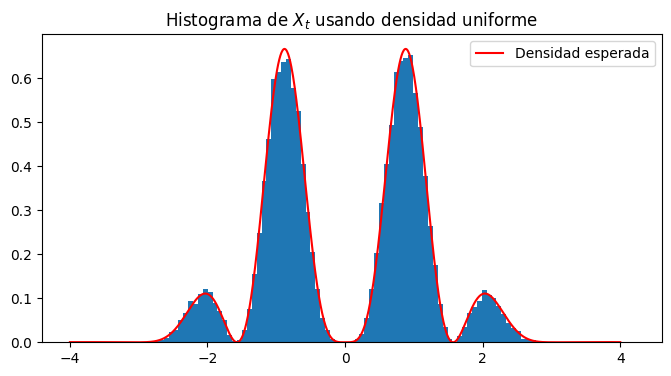

In [11]:
puntos = np.linspace(-4,4,1_000)

plt.figure(figsize = (8,4))
plt.hist(L_unif, bins = 100, density = True, zorder = 0)
plt.plot(puntos, f(puntos) / 0.2329, # normalizamos para que sea comparable
         zorder = 1, c = 'red', label = 'Densidad esperada'
        )
plt.title(f'Histograma de $X_t$ usando densidad uniforme')
plt.legend(); plt.show()

Usemos ahora la densidad instrumental de b), la densidad normal.

In [12]:
%%time
x0 = -1      # punto partida
N = 100_000 # número de simulaciones

L_normal = MH(f,g_B,x0,N) # densidad normal
L_normal

CPU times: total: 4.31 s
Wall time: 4.37 s


array([-1.        , -0.71882953, -0.87495271, ..., -1.26059635,
       -0.91937172, -0.50027603])

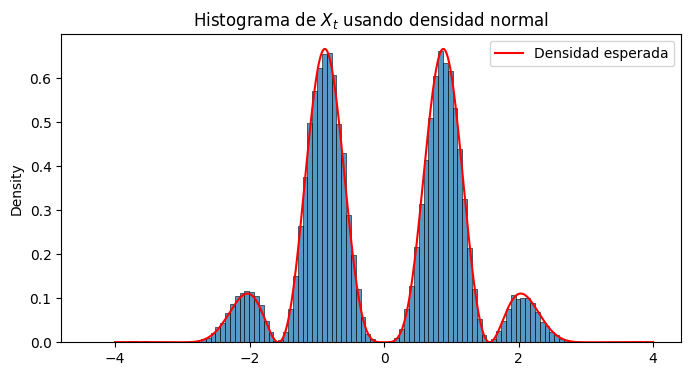

In [13]:
plt.figure(figsize = (8,4))
sns.histplot(L_normal, bins = 100, stat = 'density')
sns.lineplot(x = puntos,y =  f(puntos) / 0.2329, c = 'red', zorder = 1, label = 'Densidad esperada')
plt.title(f'Histograma de $X_t$ usando densidad normal');